In [145]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from utils.ta import *
from utils.data import get_sp500_tickers
from utils.stats import *
from utils.performance import *
from utils.etf_lists import *
from tqdm import tqdm
from datetime import datetime, date
from pandas.tseries.offsets import BDay
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.4f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Short Term Strategy That works

- This notebook tries to verfiy and follow the books "Short Term Strategy That works"

In [146]:
# start_date = datetime(2023,2,7)
# end_date = datetime.today()
# tickers = ['KRUZ', 'NANC', 'SPY']

# df = yf.download(tickers, auto_adjust=True, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
# df = merge_ta(df, rsi(df['Close'], window=2), ta_name='RSI')
# df

# Overnight vs Intraday
- Empirical study shows that Overnight retuns generally higher than intraday

- Below tries to compare the intraday returns vs overnight returns for SP500 stocks
    - Quite significant that overnight return has much higher return and risk than intraday. 
    - Risk-adjusted return of overnight is still better. Therefore, we should always be holding stocks overnight

In [147]:
tickers = get_sp500_tickers()
# tickers = ['SPY']
# tickers = get_all_etf()
# tickers = list(tickers['symbol'].unique())
start_date = datetime.today() - BDay(252*2)
end_date = datetime.today() - BDay(0)
raw = yf.download(tickers, auto_adjust=True, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

[*********************100%***********************]  503 of 503 completed


Mean    Ann. Intraday Return:  5.08%
Std.    Ann. Intraday Return:  23.46%
Sharpe. Ann. Intraday Return:  8.67%
Mean    Ann. Overnight Return: 17.78%
Std.    Ann. Overnight Return: 29.00%
Sharpe. Ann. Overnight Return: 50.80%
Pvalue of Overnight Return > Intraday Return: 0.0000%


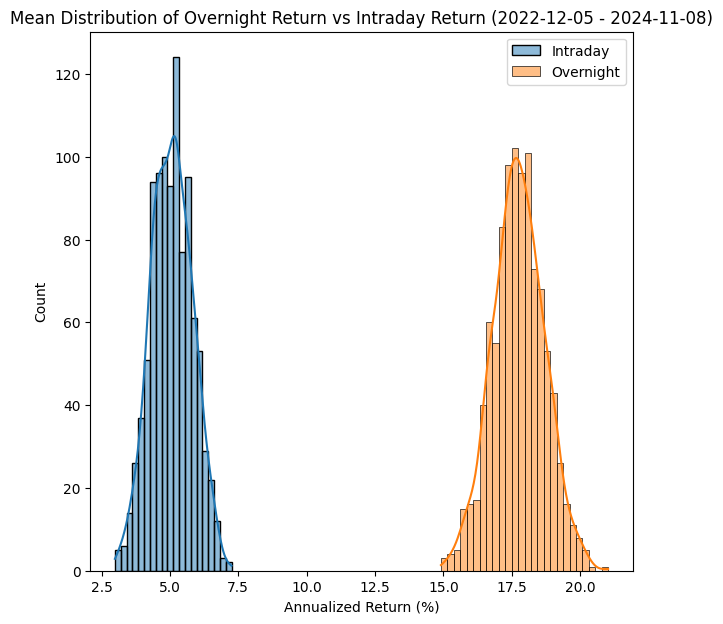

In [148]:
df = raw.copy()
df_intra = df['Close'] / df['Open'] - 1
df_overnight = (df['Close'] / df['Close'].shift(1) - 1)

ret_intra = df_intra.values.flatten()
ret_intra = ret_intra[~np.isnan(ret_intra)]
ret_intra = ret_intra

ret_overnight = df_overnight.values.flatten()
ret_overnight = ret_overnight[~np.isnan(ret_overnight)]
ret_overnight = ret_overnight

print('Mean    Ann. Intraday Return:  {:.2f}%'.format(annualized_return(ret_intra)*100))
print('Std.    Ann. Intraday Return:  {:.2f}%'.format(annualized_volatility(ret_intra)*100))
print('Sharpe. Ann. Intraday Return:  {:.2f}%'.format(annualized_sharpe_ratio(ret_intra)*100))
print("=======================================================")
print('Mean    Ann. Overnight Return: {:.2f}%'.format(annualized_return(ret_overnight)*100))
print('Std.    Ann. Overnight Return: {:.2f}%'.format(annualized_volatility(ret_overnight)*100))
print('Sharpe. Ann. Overnight Return: {:.2f}%'.format(annualized_sharpe_ratio(ret_overnight)*100))
print("=======================================================")
print('Pvalue of Overnight Return > Intraday Return: {:.4f}%'.format(ttest_ind(ret_overnight, ret_intra, alternative='greater')[1]*100))

ret_intra_bs = bootstrapped(ret_intra, k=1000)
ret_overnight_bs = bootstrapped(ret_overnight, k=1000)

fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.histplot(x=ret_intra_bs*252*100, kde=True, ax=ax, label='Intraday')
sns.histplot(x=ret_overnight_bs*252*100, kde=True, ax=ax, label='Overnight')
ax.set_title(f'Mean Distribution of Overnight Return vs Intraday Return ({start_date.strftime("%Y-%m-%d")} - {end_date.strftime("%Y-%m-%d")})')
ax.set_xlabel('Annualized Return (%)')
ax.legend()

In [149]:
def summary(df_perf, df_ben, start_date, end_date):
    df_perf_cum = cumlative_log_return(df_perf).iloc[-1]
    df_perf_sr = annualized_sharpe_ratio(df_perf)
    df_ben_cum = cumlative_log_return(df_ben).iloc[-1]
    df_ben_sr = annualized_sharpe_ratio(df_ben)

    fig, axs = plt.subplots(2,2,figsize=(14,14))
    fig.suptitle(f'{start_date.strftime("%Y-%m-%d")} - {end_date.strftime("%Y-%m-%d")}')

    ax = axs[0][0]    
    sns.histplot(x=bootstrapped(df_perf_cum.values)*100, kde=True, ax=ax, label='Strategy')
    sns.histplot(x=bootstrapped(df_ben_cum.values)*100, kde=True, ax=ax, label='Buy and Hold')
    ax.set_title(f'Mean Distribution of Cumulative Return')
    ax.set_xlabel('Cumulative Return (%)')
    ax.legend()

    rets = df_perf.values.flatten()
    rets = rets[~np.isnan(rets)]
    ben_rets = df_ben.values.flatten()
    ben_rets = ben_rets[~np.isnan(ben_rets)]

    ax = axs[0][1]
    sns.histplot(x=bootstrapped(rets)*100*252, kde=True, ax=ax, label='Strategy')
    sns.histplot(x=bootstrapped(ben_rets)*100*252, kde=True, ax=ax, label='Buy and Hold')
    ax.set_title(f'Mean Distribution of Ann. Daily Return')
    ax.set_xlabel('Ann. Daily Return (%)')
    ax.legend()

    ax = axs[1][0]
    sns.histplot(x=bootstrapped(rets[rets != 0])*100*252, kde=True, ax=ax, label='Strategy')
    sns.histplot(x=bootstrapped(ben_rets)*100*252, kde=True, ax=ax, label='Buy and Hold')
    ax.set_title(f'Mean Distribution of Ann. Daily Active Strategy Return')
    ax.set_xlabel('Ann. Daily Return (%)')
    ax.legend()

    perf_sr = df_perf_sr.values
    perf_sr = perf_sr[~np.isnan(perf_sr)]
    perf_sr = perf_sr[np.abs(perf_sr) != float('inf')]

    ben_sr = df_ben_sr.values
    ben_sr = ben_sr[~np.isnan(ben_sr)]
    ben_sr = ben_sr[np.abs(ben_sr) != float('inf')]

    ax = axs[1][1]
    sns.histplot(x=bootstrapped(perf_sr)*100, kde=True, ax=ax, label='Strategy')
    sns.histplot(x=bootstrapped(ben_sr)*100, kde=True, ax=ax, label='Buy and Hold')
    ax.set_title(f'Mean Distribution of Ann. Sharpe Ratio')
    ax.set_xlabel('Ann. Sharpe Ratio (%)')
    ax.legend()

# Simple Double's 7 Strategy

1. stocks above 200days MA
2. entry when closes at 7days low 
3. exit when closes at 7days high

### Observations
- Average returns and SR are wosen than buy and hold strategy statistically
- Even compare the active return (i.e. only when strategy is active), the returns are similar to BNH but greater variance

In [150]:
tickers = get_sp500_tickers()
# tickers = ['SPY']
# tickers = get_all_etf()
# tickers = list(tickers['symbol'].unique())
start_date = datetime.today() - BDay(252*5)
end_date = datetime.today() - BDay(0)
raw = yf.download(tickers, auto_adjust=True, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), threads=True)
if len(tickers) == 1:
    raw.columns = pd.MultiIndex.from_product([raw.columns, tickers])

[*********************100%***********************]  503 of 503 completed


Average Entry:  55 out of 1216
Average Active: 193 out of 1216


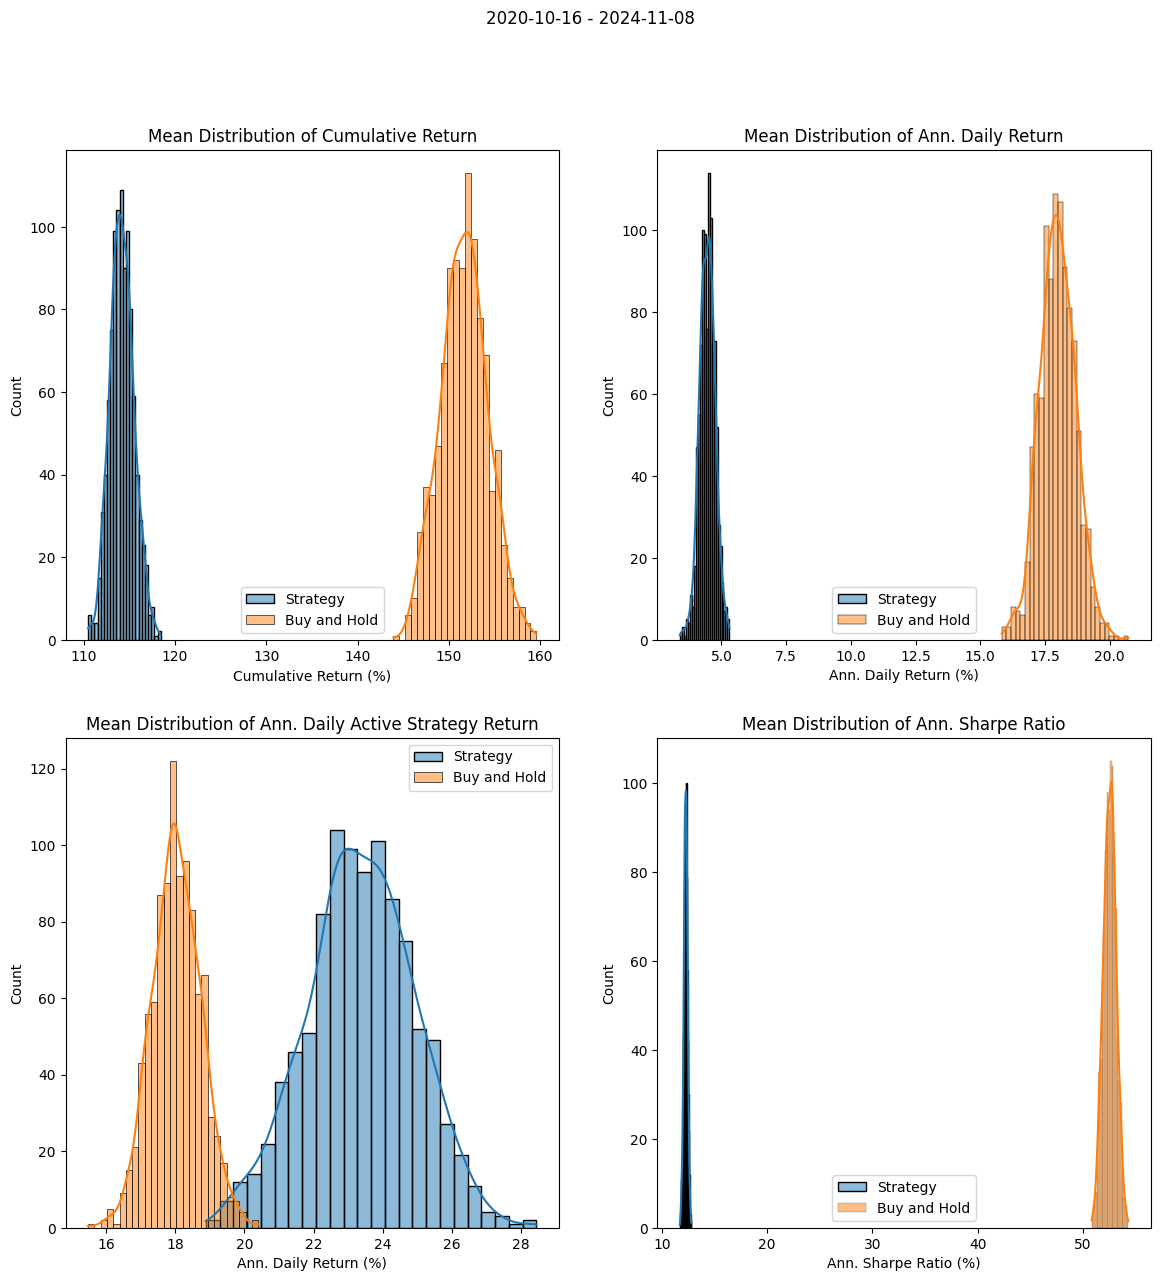

In [156]:
start_date_cutoff = start_date + BDay(200)
periods = 15

df = raw.copy()
df_close = df['Close']
df_200ma = df_close.rolling(200).mean()
df_7d_low = df_close.rolling(periods).min()
df_7d_high = df_close.rolling(periods).max()

df_entry = 1 * ((df_close == df_7d_low) & (df_close > df_200ma))
df_exit = -1 * ((df_close == df_7d_high) | (df_close < df_200ma))

df_sig = df_entry + df_exit
df_pos = df_sig.copy()

for i in range(1, len(df_pos)):
    df_pos.iloc[i] = df_pos.iloc[i] + df_pos.iloc[i-1]
    df_pos.iloc[i] = np.clip(df_pos.iloc[i], 0, 1)

# signal are determined by EOD, and traded at T+1, so postiion needs to shift by -1
# assume the entry price is T's EOD close price
df_pos = df_pos.shift(1)

df_ret = df_close / df_close.shift(1) - 1
df_perf = df_ret * df_pos
df_perf = df_perf[start_date_cutoff:]

# cumulative return of buy and hold as benchmark
df_ben = df_ret[start_date_cutoff:]
print("Average Entry:  {:.0f} out of {:.0f}".format(df_entry.sum().mean(), df_entry.shape[0]))
print("Average Active: {:.0f} out of {:.0f}".format((df_pos > 0).sum().mean(), df_entry.shape[0]))
summary(df_perf, df_ben, start_date_cutoff, end_date)

# 2 Period RSI indicators

2-period RSI indicators sorts of capturing the short terms mean reverting behavior of the stocks

1. spot price > 200MA
2. entry when 2-period RSI < 5
3. exit when price > 5MA


### Observations
- If we runs the strategy as a portfolios, the returns and SR are worsen than buy and hold
- If we compare the active returns, the returns outperforms the buy and hold strategy. 
- That means it is suitable to feed the singals into portfolio optimization rather than runnning a standalone portflios.
- The samller the RSI threshold, the better the active return, but fewer signals

Average Entry:  57 out of 1215
Average Active: 109 out of 1215


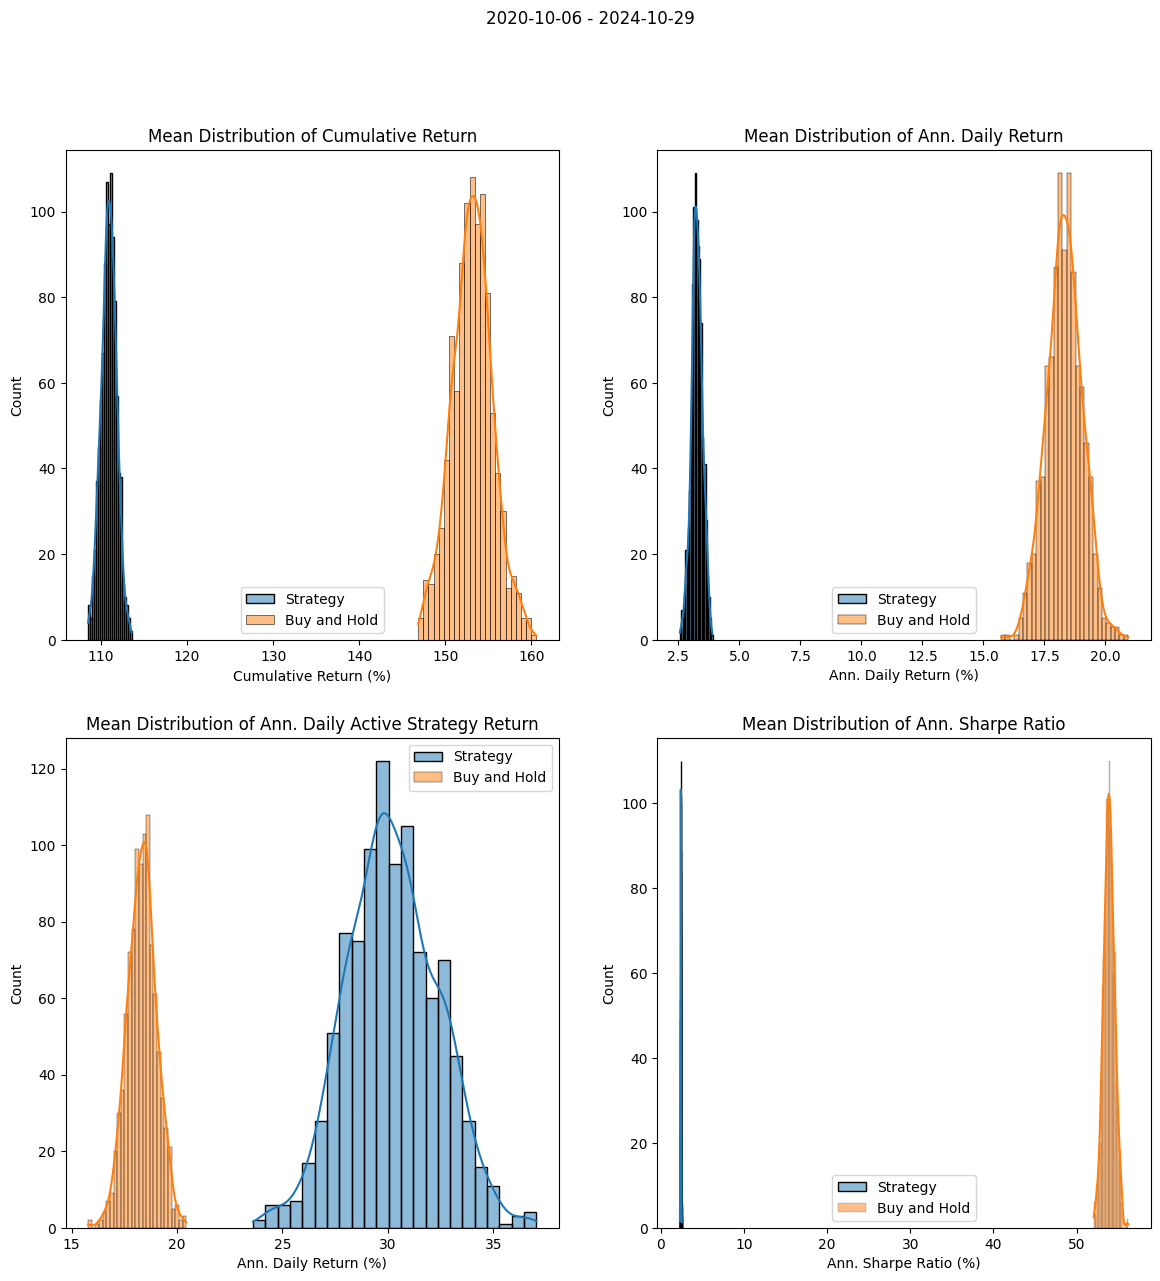

In [143]:
start_date_cutoff = start_date + BDay(200)

rsi_threshold = 10
rsi_windows = 2

df = raw.copy()
df_close = df['Close']
df_rsi = rsi(df_close, window=rsi_windows)
df_200ma = df_close.rolling(200).mean()
df_5avg = df_close.rolling(5).mean()    

df_entry = 1 * ((df_rsi < rsi_threshold) & (df_close > df_200ma))
df_exit = -1 * (df_close > df_5avg)

df_sig = df_entry + df_exit
df_pos = df_sig.copy()

for i in range(1, len(df_pos)):
    df_pos.iloc[i] = df_pos.iloc[i] + df_pos.iloc[i-1]
    df_pos.iloc[i] = np.clip(df_pos.iloc[i], 0, 1)

# signal are determined by EOD, and traded at T+1, so postiion needs to shift by -1
# assume the entry price is T's EOD close price
df_pos = df_pos.shift(1)

df_ret = df_close / df_close.shift(1) - 1
df_perf = df_ret * df_pos
df_perf = df_perf[start_date_cutoff:]

# cumulative return of buy and hold as benchmark
df_ben = df_ret[start_date_cutoff:]

print("Average Entry:  {:.0f} out of {:.0f}".format(df_entry.sum().mean(), df_entry.shape[0]))
print("Average Active: {:.0f} out of {:.0f}".format((df_pos > 0).sum().mean(), df_entry.shape[0]))
summary(df_perf, df_ben, start_date_cutoff, end_date)

# Cumulative RSI Strategy

Similar to RSI but usign cmulative 2-period RSI

- spot > 200days MA
- use 2-period RSI
- take past X days of 2-period RSI and sum them up
-  Buy if cumulative RSI is below Y
-  Exit when 2-period RSI closes above 65

Average Entry:  264 out of 1215
Average Active: 313 out of 1215


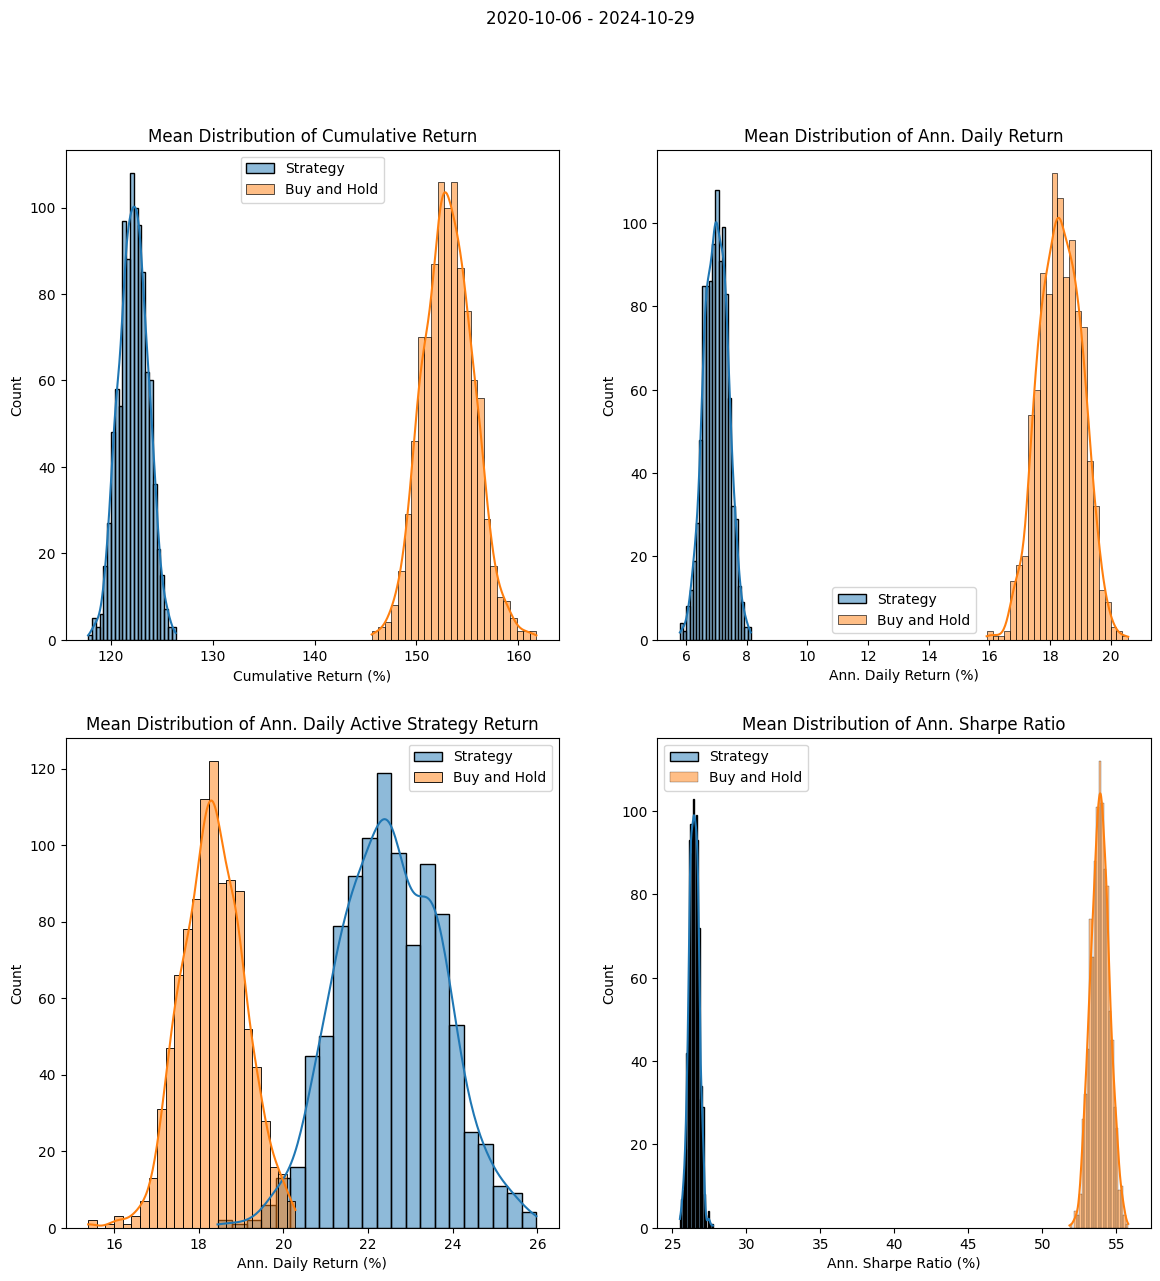

In [144]:
start_date_cutoff = start_date + BDay(200)

cum_periods = 5
entry_cum_rsi = 100
exit_rsi = 65

df = raw.copy()
df_close = df['Close']
df_rsi = rsi(df_close, window=rsi_windows)
df_rsi_cum = df_rsi.rolling(2).sum()

df_200ma = df_close.rolling(200).mean()
df_5avg = df_close.rolling(5).mean()    

df_entry = 1 * ((df_rsi_cum < entry_cum_rsi) & (df_close > df_200ma))
df_exit = -1 * (df_rsi >= exit_rsi)

df_sig = df_entry + df_exit
df_pos = df_sig.copy()

for i in range(1, len(df_pos)):
    df_pos.iloc[i] = df_pos.iloc[i] + df_pos.iloc[i-1]
    df_pos.iloc[i] = np.clip(df_pos.iloc[i], 0, 1)

# signal are determined by EOD, and traded at T+1, so postiion needs to shift by -1
# assume the entry price is T's EOD close price
df_pos = df_pos.shift(1)

df_ret = df_close / df_close.shift(1) - 1
df_perf = df_ret * df_pos
df_perf = df_perf[start_date_cutoff:]

# cumulative return of buy and hold as benchmark
df_ben = df_ret[start_date_cutoff:]

print("Average Entry:  {:.0f} out of {:.0f}".format(df_entry.sum().mean(), df_entry.shape[0]))
print("Average Active: {:.0f} out of {:.0f}".format((df_pos > 0).sum().mean(), df_entry.shape[0]))
summary(df_perf, df_ben, start_date_cutoff, end_date)